# CQPS
- 20nm notches
- CQPS constriction in the middle

<img src="data/2021-02-05_cqps/extracted-plots.png">

<img src="data/2021-02-05_cqps/mfield-summary.svg">

In [4]:
%matplotlib notebook
import logging

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("support-files/qubit.mplstyle")
from IPython.display import display
from ipywidgets import interact, interactive, interact_manual, FloatSlider, RadioButtons, Layout
import ipywidgets as widgets
from matplotlib import cm

from quantum_builder import QuantumBuilder

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
nH = 10**(-9)
GHz = 10**9
MHz = 10**6
fF = 10**(-15)
e = 1.6*10**(-19)
h = 6.64*10**(-34)
Phi0 = h/2/e

In [94]:
SIMULATION_PARAMETERS = {
    "states_per_loop": 7,
    "number_of_levels_to_simulate": 4
}
CQPS_TWIN_PARAMETERS = {
    "ES_center": 10,
    "ES_left": 10,
    "ES_right": 10,
    "inductive_loop_squares_left": 30,  # 30 140x140nm squares
    "inductive_loop_squares_right": 30,
    # Will be overriden by values below
    "EL_left": 5,
    "EL_right": 5,
    **SIMULATION_PARAMETERS
}

# Build Hamiltonian
cqps_tqubit = QuantumBuilder.build_cqps_twin_qubit(
    CQPS_TWIN_PARAMETERS,
    logging_level=logging.WARN)

<IPython.core.display.Javascript object>


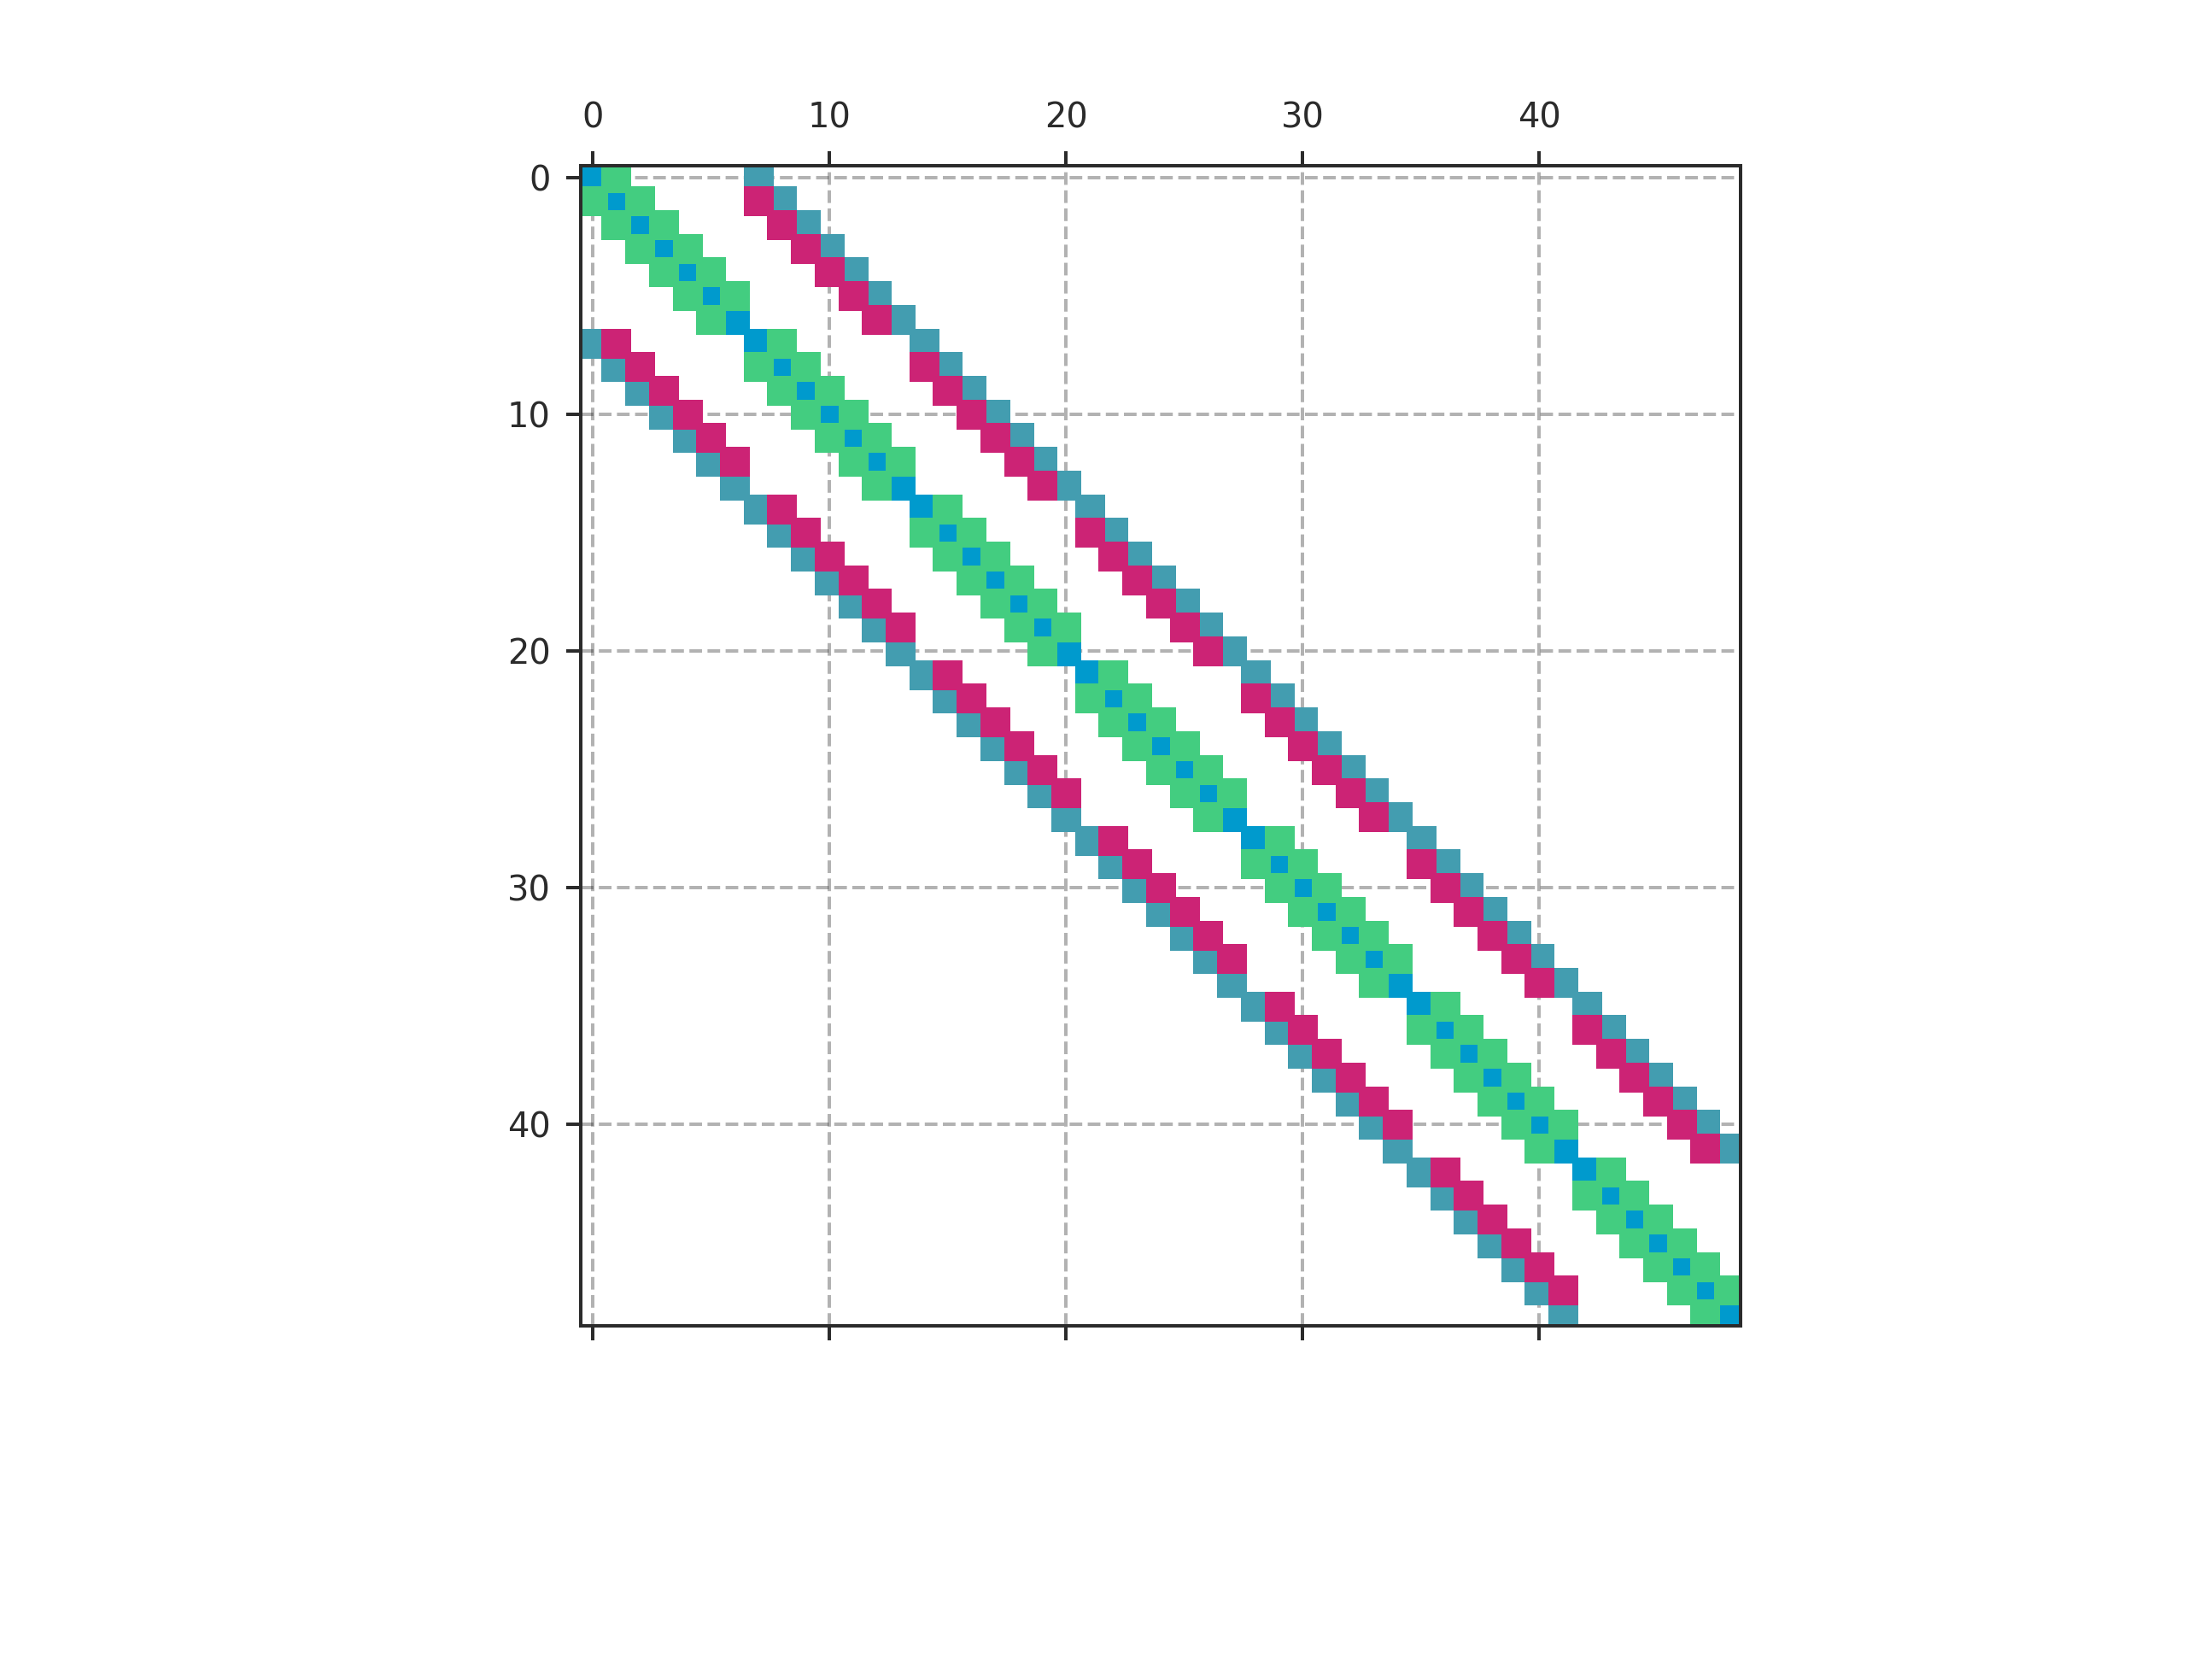

In [95]:
# Optional visualisation
from qubit.cqps_twin_qubit.cqps_twin_qubit_spare_matrix_visualizer import CQPSTwinQubitSparseMatrixVisualiser

cqps_tqubit.cqps_twin_qubit_hamiltonian_manager.stage1_prepare_hamiltonian_skeleton()

fig, ax = plt.subplots(1, 1, figsize=(4,3))
matrixVisualiser = CQPSTwinQubitSparseMatrixVisualiser(
    cqps_tqubit.cqps_twin_qubit_hamiltonian_manager, cqps_tqubit.cqps_twin_qubit_constant_manager)
matrixVisualiser.visualise_matrix(ax)
# plt.savefig("./output/cqps-twin_matrix-visualisation.svg")

## TiN95_TwinQ_3Feb'21_mfield_04_data-A.txt

In [8]:
FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-A.txt"

PERIOD = 0.37 - -0.0646
OFFSET = -0.638

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x) / PERIOD - OFFSET
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

In [9]:
# Seed initial values
EL_left = 21.6
ES = 13.3
ES_on_sides = 11.1
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES=ES,
    ES_on_sides=ES_on_sides
)
FLUX_NUMBER = np.linspace(-1, 2, 101)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
    }, number_of_levels_to_simulate=SIMULATION_PARAMETERS[
        "number_of_levels_to_simulate"],
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.bone)
simulation_01, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 1] -
     simulation["eigvals"][:, 0, 0]),
    color=MY_COLOURS["Orange"], alpha=0.3
)
simulation_12, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 2] -
     simulation["eigvals"][:, 0, 1]),
)

ax.set_xlim([data3d_x[0], data3d_x[-1]])
ax.set_ylim([data3d_y[0], data3d_y[-1]])
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

plt.tight_layout()

<IPython.core.display.Javascript object>

In [57]:
# Interactive plot
def cqps_plot(EL_left, EL_right, ES, ES_on_sides):
    cqps_tqubit.override_parameters(
        EL_left=EL_left, EL_right=EL_left, ES=ES, ES_on_sides=ES_on_sides)
    
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
    
    simulation_01.set_ydata(
        simulation["eigvals"][:, 0, 1] - simulation["eigvals"][:, 0, 0])
    simulation_12.set_ydata(
        simulation["eigvals"][:, 0, 2] - simulation["eigvals"][:, 0, 1])

EL_left_widget = FloatSlider(
    min=0, max=100,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=0, max=100,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_widget = FloatSlider(
    min=0, max=100,
    description="ES (GHz)", value=ES,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_on_sides_widget = FloatSlider(
    min=0, max=20,
    description="ES_on_sides (GHz)", value=ES_on_sides,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([EL_left_widget, EL_right_widget, ES_widget, ES_on_sides_widget])

out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES": ES_widget,
        "ES_on_sides": ES_on_sides_widget
    }
)  

display(ui, out)

Output()

In [41]:
plt.savefig(FILENAME.replace("txt","pdf"), dpi=100)

## TiN95_TwinQ_3Feb'21_mfield_04_data-B.txt
Associated with qubit 1 in design:
- 38.45 squares of NbN
- 12nm constriction - similar to constrictions in cqps paper which range from 0.1-4GHz
- 20nm outer constrictions so should be below 1GHz

In [8]:
# Repetition period
x = [ -0.482, -0.062, 0.3551]
for i in range(0, len(x)-1):
    print(x[i+1] - x[i])   
    
# TiN inductance to evaluate energy
L = 38.45 * 6*nH
EL = cqps_tqubit.cqps_twin_qubit_constant_manager.generic_converter.convert_energy_to_GHz(
    Phi0**2 / 2 / L)
print(EL)

L = 38.45 * 2*nH
EL = cqps_tqubit.cqps_twin_qubit_constant_manager.generic_converter.convert_energy_to_GHz(
    Phi0**2 / 2 / L)
print(EL)

0.42
0.4171
14.053695275249238
42.16108582574772


In [21]:
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-B.txt"
# ES_center = 36
# ES_left = 5.1
# PERIOD = 0.419
# OFFSET = -.155
# EL_left = 25.8

FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-B1.txt"
PERIOD = 0.42
OFFSET = -.155 + 0.5

ES_center = 5
ES_left = 0.2
EL_left = 25.8

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x) / PERIOD - OFFSET
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


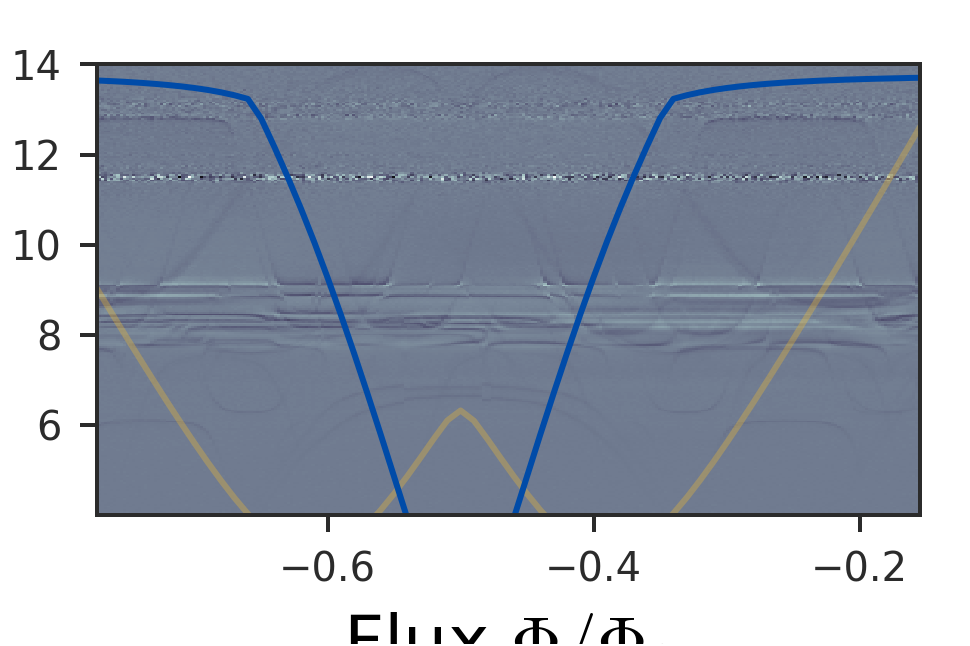

Text(0, 0.5, 'Frequency $\\omega/2\\pi$ (GHz)')

In [22]:
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES_center=ES_center,
    ES_left=ES_left,
    ES_right=ES_left
)
FLUX_NUMBER = np.linspace(-1, 1, 201)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
        "assymetry": 1.0
    }, number_of_levels_to_simulate=SIMULATION_PARAMETERS[
        "number_of_levels_to_simulate"],
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax_arr = plt.subplots(1, 1, figsize=(1.5, 1))
# ax = ax_arr[0]
# simulation_0, = ax.plot(
#     FLUX_NUMBER,
#     simulation["eigvals"][:, 0, 0]
# )
# simulation_1, = ax.plot(
#     FLUX_NUMBER,
#     simulation["eigvals"][:, 0, 1]
# )
# simulation_2, = ax.plot(
#     FLUX_NUMBER,
#     simulation["eigvals"][:, 0, 2]
# )
# simulation_3, = ax.plot(
#     FLUX_NUMBER,
#     simulation["eigvals"][:, 0, 3]
# )
ax = ax_arr
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.bone)
simulation_01, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 1] -
     simulation["eigvals"][:, 0, 0]),
    color=MY_COLOURS["Orange"], alpha=0.3
)
simulation_12, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 2] -
     simulation["eigvals"][:, 0, 1]),
)
# simulation_32, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 3] -
#      simulation["eigvals"][:, 0, 2]), color="red"
# )
# simulation_20, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 2] -
#      simulation["eigvals"][:, 0, 0]), color="green"
# )
# simulation_31, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 3] -
#      simulation["eigvals"][:, 0, 1]), color="purple"
# )


ax.set_xlim([data3d_x[0], data3d_x[-1]])
ax.set_ylim([data3d_y[0], data3d_y[-1]])
# ax.set_ylim([5, 20])
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# plt.tight_layout()
# plt.savefig("./data/2021-02-05_cqps/energy-level-simulation.svg")

In [23]:
# Interactive plot
def cqps_plot(EL_left, EL_right, ES_center, ES_right, ES_left,assymetry):
    cqps_tqubit.override_parameters(
        EL_left=EL_left, 
        EL_right=EL_right, 
        ES_center=ES_center, ES_left=ES_left, ES_right=ES_right)
    
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
            "assymetry": assymetry
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
#     simulation_0.set_ydata(simulation["eigvals"][:, 0, 0])
#     simulation_1.set_ydata(simulation["eigvals"][:, 0, 1])
#     simulation_2.set_ydata(simulation["eigvals"][:, 0, 2])
#     simulation_3.set_ydata(simulation["eigvals"][:, 0, 3])
    simulation_01.set_ydata(
        simulation["eigvals"][:, 0, 1]
        - simulation["eigvals"][:, 0, 0]
    )
    simulation_12.set_ydata(
        simulation["eigvals"][:, 0, 2]
        - simulation["eigvals"][:, 0, 1]
    )
#     simulation_32.set_ydata(
#         simulation["eigvals"][:, 0, 3]
#         - simulation["eigvals"][:, 0, 2]
#     )
#     simulation_20.set_ydata(
#         simulation["eigvals"][:, 0, 2]
#         - simulation["eigvals"][:, 0, 0]
#     )
#     simulation_31.set_ydata(
#         simulation["eigvals"][:, 0, 3]
#         - simulation["eigvals"][:, 0, 1]
#     )

EL_left_widget = FloatSlider(
    min=5, max=50,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=5, max=50,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_center_widget = FloatSlider(
    min=0, max=20,
    description="ES_center (GHz)", value=ES_center,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_left_widget = FloatSlider(
    min=0, max=2,
    description="ES_left (GHz)", value=ES_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_right_widget = FloatSlider(
    min=0, max=2,
    description="ES_right (GHz)", value=ES_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
assymetry_widget = FloatSlider(
    min=0.95, max=1.05, step=0.005,
    description="Assymetry", value=1,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([
    EL_left_widget, EL_right_widget, ES_center_widget,
    ES_left_widget,ES_right_widget, assymetry_widget])

out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES_center": ES_center_widget,
        "ES_left": ES_left_widget,
        "ES_right": ES_right_widget,
        "assymetry": assymetry_widget
    }
)  

display(ui, out)

Output()

In [80]:
plt.savefig(FILENAME.replace("txt","pdf"), dpi=100)

## TiN95_TwinQ_3Feb'21_mfield_06_data-C.txt
Associated with qubit 7:
- 11nm constrictions
- 20nm outside constrictions
- 42.35 squares

In [73]:
# Minima positions
x = [-0.3713, -0.1663, 0.0386, 0.2452]
for i in range(0, len(x)-1):
    print(x[i+1] - x[i])
    
# TiN inductance to evaluate energy
L = 42.35 * 6*nH
EL = cqps_tqubit.cqps_twin_qubit_constant_manager.generic_converter.convert_energy_to_GHz(
    Phi0**2 / 2 / L)
print(EL)

L = 42.35 * 2*nH
EL = cqps_tqubit.cqps_twin_qubit_constant_manager.generic_converter.convert_energy_to_GHz(
    Phi0**2 / 2 / L)
print(EL)

0.20500000000000002
0.2049
0.2066
12.759494293585199
38.2784828807556


In [136]:
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_06_data-C.txt"
PERIOD = 0.205*2
OFFSET = -0.050
# EL_left = 10.4
# ES_center = 6.2
# ES_left = 0.5

FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-C.txt"
PERIOD = 0.207*2
OFFSET = -0.050 - 0.1

EL_left = 20
ES_center = 12.8
ES_left = 0.9

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x) / PERIOD - OFFSET
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


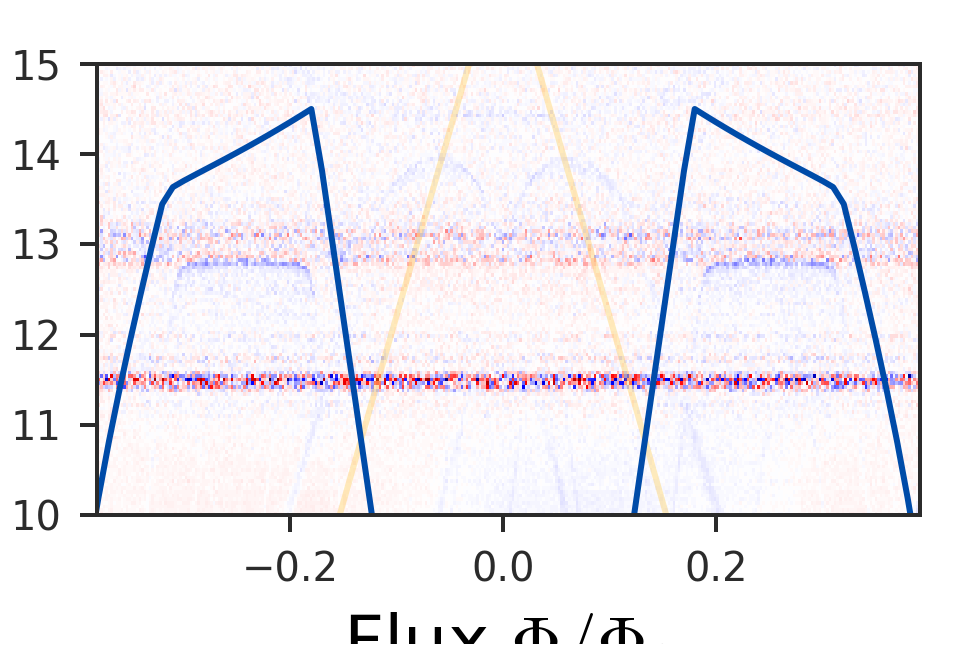

Text(0, 0.5, 'Frequency $\\omega/2\\pi$ (GHz)')

In [137]:
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES_center=ES_center,
    ES_left=ES_left,
    ES_right=ES_left
)
# FLUX_NUMBER = np.linspace(0.1, 0.4, 301)
FLUX_NUMBER = np.linspace(-0.5, 0.5, 101)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
        "assymetry": 1.0
    }, number_of_levels_to_simulate=SIMULATION_PARAMETERS[
        "number_of_levels_to_simulate"],
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax_arr = plt.subplots(1, 1, figsize=(1.5, 1))
ax = ax_arr
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.seismic)
simulation_01, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 1] -
     simulation["eigvals"][:, 0, 0]),
    color=MY_COLOURS["Orange"], alpha=0.3
)
simulation_12, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 2] -
     simulation["eigvals"][:, 0, 1]),
)
# simulation_32, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 3] -
#      simulation["eigvals"][:, 0, 2]), color="red"
# )
# simulation_20, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 2] -
#      simulation["eigvals"][:, 0, 0]), color="green"
# )
# simulation_31, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 3] -
#      simulation["eigvals"][:, 0, 1]), color="purple"
# )


ax.set_xlim([data3d_x[0], data3d_x[-1]])
ax.set_ylim([data3d_y[0], data3d_y[-1]])
ax.set_ylim([10, 15])
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# plt.tight_layout()
# plt.savefig("./data/2021-02-05_cqps/energy-level-simulation.svg")

In [138]:
# Interactive plot
def cqps_plot(EL_left, EL_right, ES_center, ES_right, ES_left,assymetry):
    cqps_tqubit.override_parameters(
        EL_left=EL_left, 
        EL_right=EL_right, 
        ES_center=ES_center, ES_left=ES_left, ES_right=ES_right)
    
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
            "assymetry": assymetry
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
    simulation_01.set_ydata(
        simulation["eigvals"][:, 0, 1]
        - simulation["eigvals"][:, 0, 0]
    )
    simulation_12.set_ydata(
        simulation["eigvals"][:, 0, 2]
        - simulation["eigvals"][:, 0, 1]
    )
#     simulation_32.set_ydata(
#         simulation["eigvals"][:, 0, 3]
#         - simulation["eigvals"][:, 0, 2]
#     )
#     simulation_20.set_ydata(
#         simulation["eigvals"][:, 0, 2]
#         - simulation["eigvals"][:, 0, 0]
#     )
#     simulation_31.set_ydata(
#         simulation["eigvals"][:, 0, 3]
#         - simulation["eigvals"][:, 0, 1]
#     )

EL_left_widget = FloatSlider(
    min=5, max=50,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=5, max=50,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_center_widget = FloatSlider(
    min=0, max=20,
    description="ES_center (GHz)", value=ES_center,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_left_widget = FloatSlider(
    min=0, max=5,
    description="ES_left (GHz)", value=ES_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_right_widget = FloatSlider(
    min=0, max=5,
    description="ES_right (GHz)", value=ES_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
assymetry_widget = FloatSlider(
    min=0.95, max=1.05, step=0.005,
    description="Assymetry", value=1,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([
    EL_left_widget, EL_right_widget, ES_center_widget,
    ES_left_widget,ES_right_widget, assymetry_widget])

out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES_center": ES_center_widget,
        "ES_left": ES_left_widget,
        "ES_right": ES_right_widget,
        "assymetry": assymetry_widget
    }
)  

display(ui, out)

Output()

In [41]:
plt.savefig(FILENAME.replace("txt","pdf"), dpi=100)

## TiN95_TwinQ_3Feb'21_mfield_1-2-3_comb
 
| **Series** | `ES` (GHz) | `EL` (GHz) |
|------------|------------|------------|
| A          | 7.7        | 12.9       |
| B          | NA         | NA         |
| C          | NA         | NA         |
| D          | NA         | NA         |
| E          | 6.3        | 19.4       |

<IPython.core.display.Javascript object>


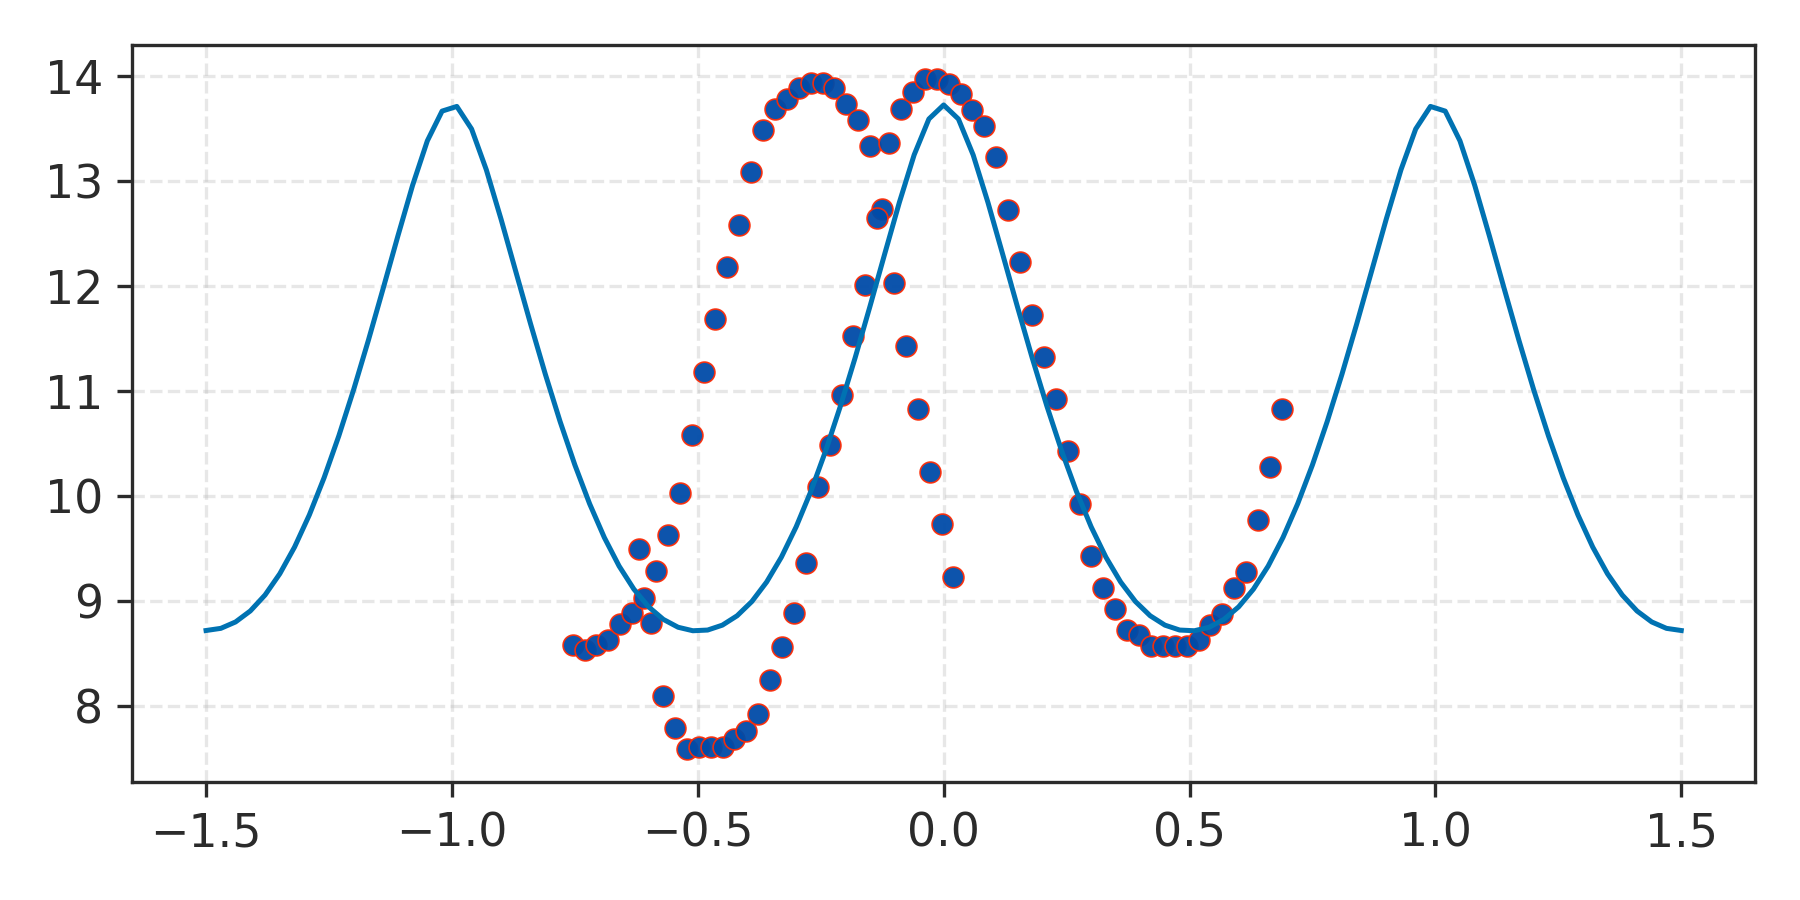

In [6]:
FILES = {
    "A": "#00147f",
    "B": "#ed2200",     # dark red (red2)
    "C": "#ffc125",      # orange,
    "D": "#8b6969",
    "E": "#cd9b1d"
}
data = {}

# Selection of data to fit
series = "A"
scaling = 4.84
offset = 1.85
FILE = "TiN95_TwinQ_3Feb'21_mfield_1-2-3_comb"
data_series = np.loadtxt(f"{BASE_NAME}/{FILE}-{series}.txt")

EL_left = 13
ES = 4.1
ES_on_sides = 7.7
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES=ES,
    ES_on_sides=ES_on_sides
)
FLUX_NUMBER = np.linspace(-1.5, 1.5, 101)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
    }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"],
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
data_graph, = ax.plot(data_series[:, 0] * scaling - offset, data_series[:, 1],
                      marker="o",
                      markeredgecolor="#fb2c07",
                      markeredgewidth="0.4",
                      markersize=5,
                      alpha=0.95,
                      linestyle="")
# Double wrapped simulations since there is option to vary phi2
simulation_graph, = ax.plot(
    FLUX_NUMBER, simulation["eigvals"][:, 0, 1] -
    simulation["eigvals"][:, 0, 0],
)

plt.tight_layout()
# ax.set_ylim([0, 10])

# Interactive plot
def cqps_plot(EL_left: float, EL_right: float, ES: float, ES_on_sides: float, scaling: float, offset: float):
    cqps_tqubit.override_parameters(EL_left=EL_left, EL_right=EL_right, ES=ES, ES_on_sides=ES_on_sides)
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
    simulation_graph.set_ydata(
        simulation["eigvals"][:, 0, 1] - simulation["eigvals"][:, 0, 0])
    data_graph.set_xdata(data_series[:, 0] * scaling - offset)


scaling_widget = FloatSlider(
    min=0, max=20, step=0.1,
    description="Scaling", value=scaling,
    layout=Layout(width='90%'),
    continuous_update=False
)
offset_widget = FloatSlider(
    min=-3, max=3, step=0.02,
    description="Offset", value=offset,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_left_widget = FloatSlider(
    min=0, max=100,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=0, max=100,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_widget = FloatSlider(
    min=0, max=100,
    description="ES (GHz)", value=ES,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_on_sides_widget = FloatSlider(
    min=0, max=100,
    description="ES_on_sides (GHz)", value=ES_on_sides,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([EL_left_widget, EL_right_widget, ES_widget, ES_on_sides_widget, scaling_widget, offset_widget])
plt.savefig

In [39]:
out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES": ES_widget,
        "ES_on_sides": ES_on_sides_widget,
        "scaling": scaling_widget,
        "offset": offset_widget
    }
)  

display(ui, out)

Output()

## TiN95_TwinQ_3Feb'21_mfield_05_data.vi 

<IPython.core.display.Javascript object>


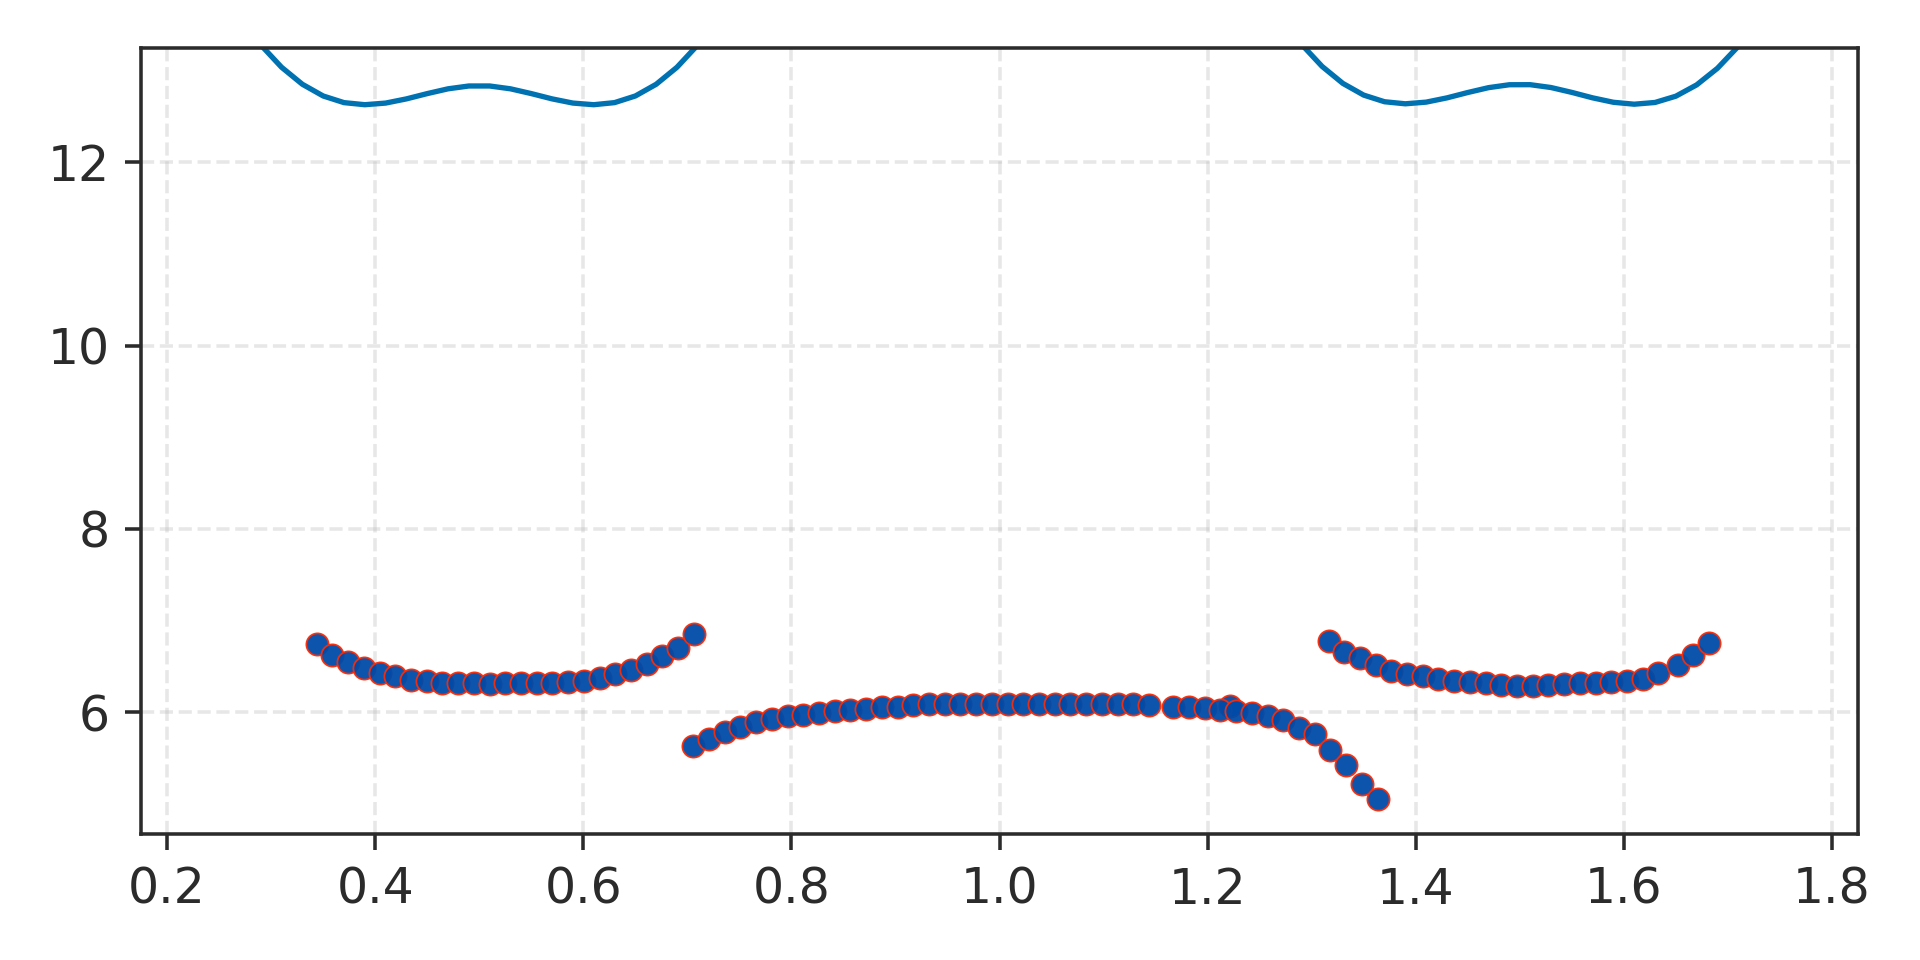

In [94]:
# Selection of data to fit
scaling = 15.1
offset = -0.4
FILE = "TiN95_TwinQ_3Feb'21_mfield_05_data"
data_series = np.loadtxt(f"{BASE_NAME}/{FILE}.txt")

EL_left = 14.2
ES = 5.7
ES_on_sides = 4.6
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES=ES,
    ES_on_sides=ES_on_sides
)
FLUX_NUMBER = np.linspace(0.25, 1.75, 76)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
    }, number_of_levels_to_simulate=2,
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
data_graph, = ax.plot(data_series[:, 0] * scaling - offset, data_series[:, 1],
                      marker="o",
                      markeredgecolor="#fb2c07",
                      markeredgewidth="0.4",
                      markersize=5,
                      alpha=0.95,
                      linestyle="")
# Double wrapped simulations since there is option to vary phi2
simulation_graph, = ax.plot(
    FLUX_NUMBER, simulation["eigvals"][:, 0, 1] -
    simulation["eigvals"][:, 0, 0],
)

plt.tight_layout()
# ax.set_ylim([0, 10])

# Interactive plot
def cqps_plot(EL_left: float, EL_right: float, ES: float, ES_on_sides: float, scaling: float, offset: float):
    cqps_tqubit.override_parameters(EL_left=EL_left, EL_right=EL_right, ES=ES, ES_on_sides=ES_on_sides)
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
    simulation_graph.set_ydata(
        simulation["eigvals"][:, 0, 1] - simulation["eigvals"][:, 0, 0])
    data_graph.set_xdata(data_series[:, 0] * scaling - offset)


scaling_widget = FloatSlider(
    min=0, max=20, step=0.1,
    description="Scaling", value=scaling,
    layout=Layout(width='90%'),
    continuous_update=False
)
offset_widget = FloatSlider(
    min=-3, max=3, step=0.02,
    description="Offset", value=offset,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_left_widget = FloatSlider(
    min=0, max=100,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=0, max=100,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_widget = FloatSlider(
    min=0, max=100,
    description="ES (GHz)", value=ES,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_on_sides_widget = FloatSlider(
    min=0, max=100,
    description="ES_on_sides (GHz)", value=ES_on_sides,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([EL_left_widget, EL_right_widget, ES_widget, ES_on_sides_widget, scaling_widget, offset_widget])

In [95]:
out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES": ES_widget,
        "ES_on_sides": ES_on_sides_widget,
        "scaling": scaling_widget,
        "offset": offset_widget
    }
)  

display(ui, out)

Output()

# Multiple

<IPython.core.display.Javascript object>


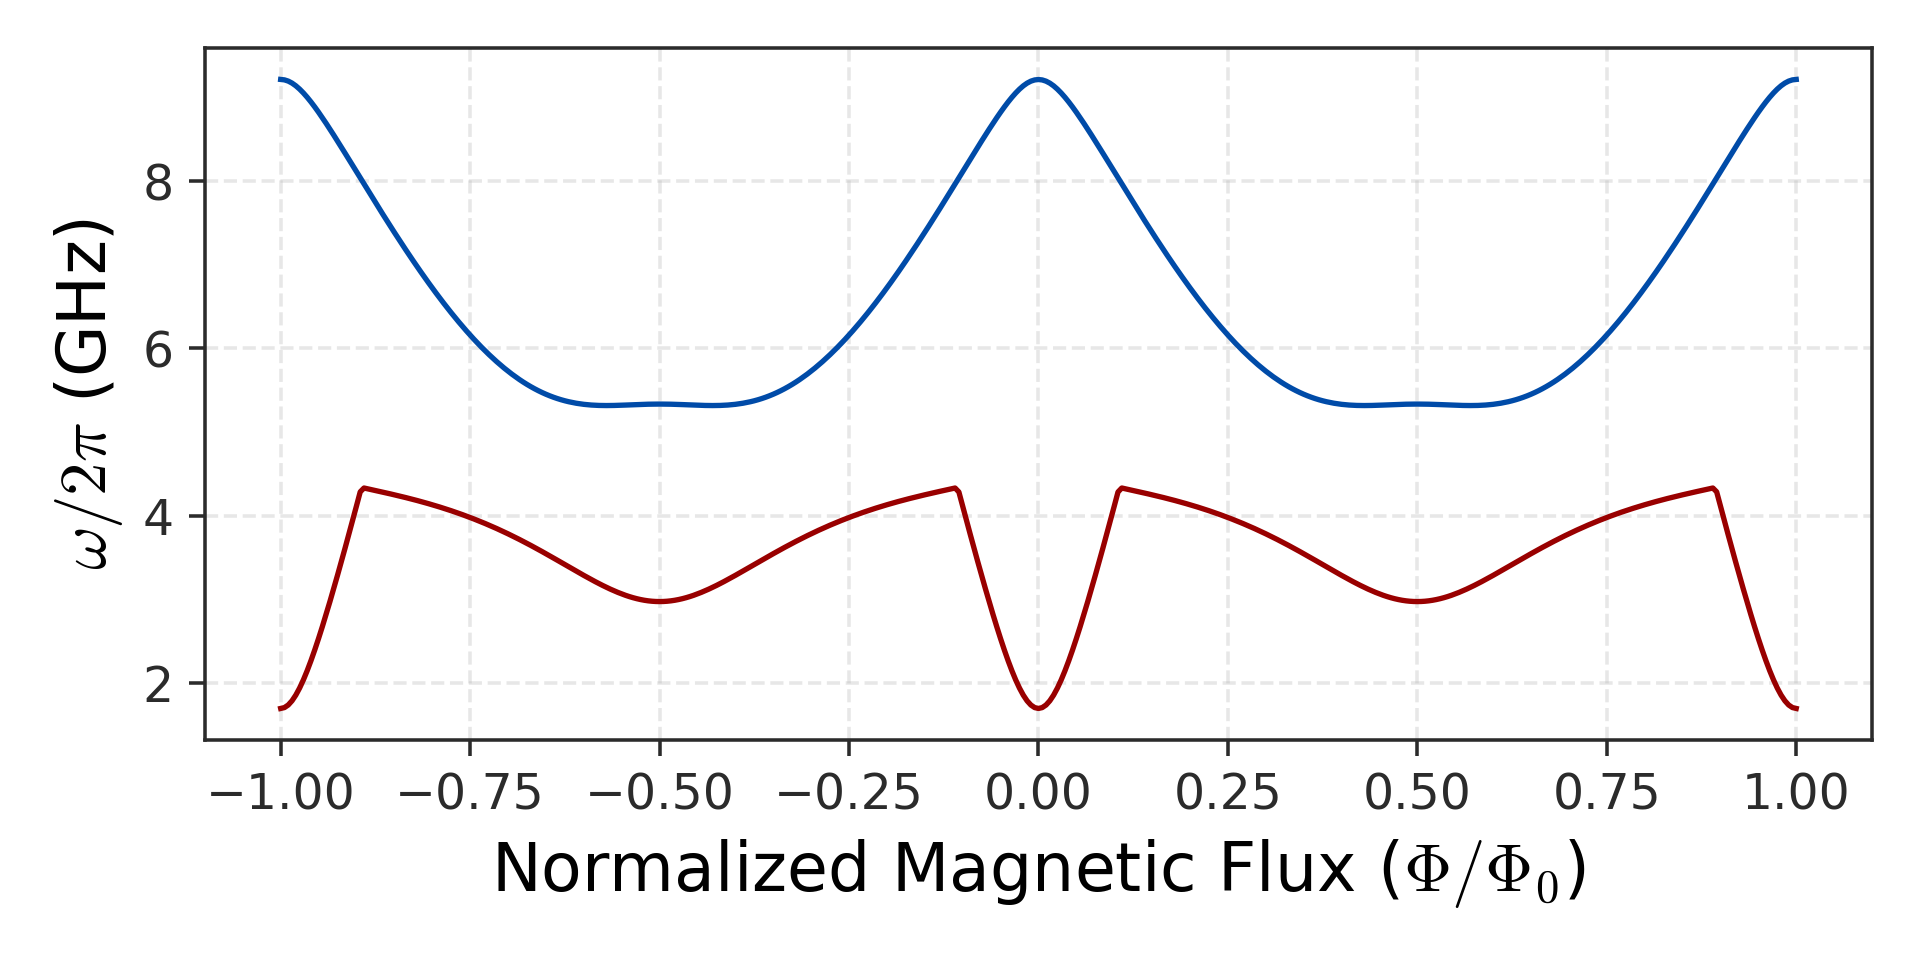

In [89]:
EL_left = 10
ES = 5
ES_on_sides = 4
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES=ES,
    ES_on_sides=ES_on_sides
)
FLUX_NUMBER = np.linspace(-1, 1, 401)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
    }, number_of_levels_to_simulate=4,
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# Double wrapped simulations since there is option to vary phi2
simulation_graph, = ax.plot(
    FLUX_NUMBER, simulation["eigvals"][:, 0, 1] -
    simulation["eigvals"][:, 0, 0], color="C0"
)
simulation_graph, = ax.plot(
    FLUX_NUMBER, simulation["eigvals"][:, 0, 2] -
    simulation["eigvals"][:, 0, 1], color="C4"
)

ax.set_xlabel("Normalized Magnetic Flux ($\Phi/\Phi_0$)", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)    
plt.tight_layout()

plt.savefig(f"./output/2021-03_cqps/cqps_spectrum.svg", transparent=True)

# Integrating profile

In [39]:
SIDE_CONSTRICTION_WIDTH = 0.02
TRIANGLE_IN = [
    # Narrow first
    (1.4, 0.1), 
    # Then flat bar
    (0.47, 0.1)]
TRIANGLE_OUT = [
    # Flat bar
    (0, 0.1),
    (0.47, 0.1),
    # Triangle out
    (1.4, 1.4)
]
SIDE_CONSTRICTION = [
    # Narrow to constriction
    (0, SIDE_CONSTRICTION_WIDTH),
    (0.05, SIDE_CONSTRICTION_WIDTH)
]

def create_loop_profile(loop_profile: list):
    position = [0]
    width = [1.4]
    
    for (l, w) in loop_profile:
        position.append(position[-1] + l)
        width.append(w)
    return (position, width)

## Example plot

In [37]:
constriction = 0.011
(position, width) = create_loop_profile([
    # Wide
    (3.2 + 1.4, 1.4),
    (3.7, 1.4),
    (3.2 + 1.4, 1.4),
    *TRIANGLE_IN,
    *SIDE_CONSTRICTION,
    *TRIANGLE_OUT,
    # Wide
    (3.2 + 1.4, 1.4),
    (3.7, 1.4),
    (3.2 + 1.4, 1.4),
    # Triangle
    *TRIANGLE_IN,
    (0, constriction),
    (0.05, constriction),
    *TRIANGLE_OUT
])
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(position, width, color=MY_COLOURS["DarkBlue"])
ax.set_xlabel("$\mu{m}$")
ax.set_ylabel("Width $(\mu{m})$")
plt.tight_layout()

plt.savefig("./data/2021-02-05_cqps/11nm-profile.svg")

<IPython.core.display.Javascript object>

## 11nm

In [43]:
# Then, to evaluate we chop up into separate blocks
(
    # Wide sections
    (3.2 + 1.4 + 3.7 + 3.2 + 1.4 + 3.2 + 1.4 + 3.7 + 1.4) / 1.4
    +
    # Narrowing
    (0.47 + 0.47) / 0.1
    # Constrictions
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    + (0.05) / constriction
    # Triangles
    + 4 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

42.35228057178803

## 12nm

In [44]:
constriction = 0.012
(
    # Wide sections
    (1.85 + 3.8 + 1.85 + 1.95 + 5.15 + 0.55) / 1.4
    +
    # Narrowing
    (0.48 + 0.48) / 0.1
    # Constrictions
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    + (0.05) / constriction
    # Triangles
    + 4 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

38.45634219643789

## 17nm

In [46]:
constriction = 0.017
(
    # Wide sections
    (1.85 + 7.3 + 1.85 + 1.95 + 8.55 + 0.55) / 1.4
    +
    # Narrowing
    (0.48 + 0.48) / 0.1
    # Constrictions
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    + (0.05) / constriction
    # Triangles
    + 4 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

42.15942342893089

## 9nm - joined

In [48]:
constriction = 0.009
(
    # Wide sections
    (4.5 + 4.5 + 10 + 4.5 + 4.5 + 10) / 1.4
    +
    # Narrowing
    (0.48 + 0.48) / 0.1
    # Constrictions
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    # Triangles
    + 4 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

53.1111041011998

## 8nm - joined

In [49]:
constriction = 0.008
(
    # Wide sections
    (4.5 + 4.5 + 10.2 + 4.5 + 4.5 + 10.2) / 1.4
    +
    # Narrowing
    (0.48 + 0.48) / 0.1
    # Constrictions
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    # Triangles
    + 4 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

53.396818386914084